In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
from visualize import draw_dot
import requests
from nn import Embedding
from nn import Linear, Model
from optimize import Adam

/Users/noahs/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [1]:
l1 = Linear(1, 20, activation='relu')
l2 = Linear(20, 1)
batch_size=1

model = Model([l1, l2])
optim = Adam(model)

NameError: name 'Linear' is not defined

In [2]:
X = np.random.uniform(0, 10000000, 1000)
Y = 2*X**2

X_norm = (X - np.mean(X)) / np.std(X)
Y_norm = (Y - np.mean(Y)) / np.std(Y)

NameError: name 'np' is not defined

In [9]:
for _ in (t:=trange(1000)):
    ix = np.random.randint(0, X_norm.shape[0], (batch_size,)).flatten()

    out = model(X_norm[ix])
    
    optim.zero_grad()

    if (batch_size > 1):
        batch_loss = sum([((val-Y_norm[ix][i])**2)/batch_size for i, val in enumerate(out)])
        batch_loss.backward()
    
    else:
        
        loss = (out-Y_norm[ix][0])**2
        loss.backward()

    optim.step()

    t.set_description(f'loss: {batch_loss.data}')

loss: 3.2946033731263173: 100%|██████████| 1000/1000 [00:01<00:00, 660.60it/s]


In [ ]:
avg_loss = 0
count = 0
for x, y in zip(X_norm, Y_norm):
    out = model([x])
    loss = (out - y) ** 2
    avg_loss += loss.data
    count += 1
print(f'avg_loss: {avg_loss/count}')

avg_loss: 0.11549137168919044


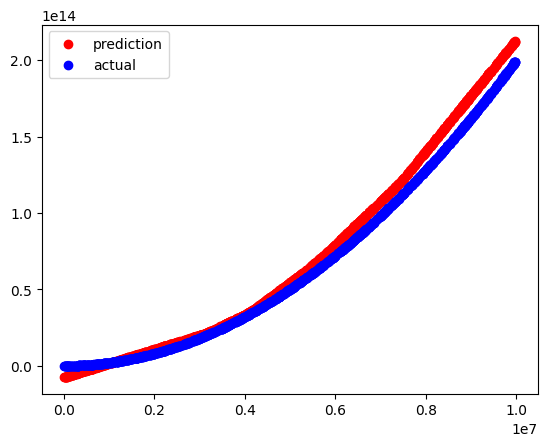

In [34]:
plt.scatter(X, np.array([model([x]).data for x in X_norm]) * np.std(Y) + np.mean(Y), c='r', label='prediction')
plt.scatter(X, Y, c='b', label='actual')
plt.legend()

In [ ]:
import numpy as np
import onnx
from onnx import TensorProto
from onnx.helper import make_model, make_node, make_graph, make_tensor_value_info, make_tensor

def build_model(name='model'):
    input_dim = 1
    hidden_units = 5
    output_dim = 1

    X = make_tensor_value_info('X', TensorProto.FLOAT, [None, input_dim])
    Y = make_tensor_value_info('Y', TensorProto.FLOAT, [None, output_dim])

    W1_values = np.random.randn(input_dim, hidden_units).astype(np.float32)
    B1_values = np.random.randn(hidden_units).astype(np.float32)
    W1 = make_tensor('W1', TensorProto.FLOAT, [input_dim, hidden_units], W1_values)
    B1 = make_tensor('B1', TensorProto.FLOAT, [hidden_units], B1_values)

    W2_values = np.random.randn(hidden_units, output_dim).astype(np.float32)
    B2_values = np.random.randn(output_dim).astype(np.float32)
    W2 = make_tensor('W2', TensorProto.FLOAT, [hidden_units, output_dim], W2_values)
    B2 = make_tensor('B2', TensorProto.FLOAT, [output_dim], B2_values)

    nodes = [
        make_node('MatMul', ['X', 'W1'], ['XW1']),
        make_node('Add', ['XW1', 'B1'], ['XW1B1']),
        make_node('Relu', ['XW1B1'], ['Relu1']),
        make_node('MatMul', ['Relu1', 'W2'], ['Relu1W2']),
        make_node('Add', ['Relu1W2', 'B2'], ['Y'])
    ]

    graph = make_graph(nodes, name, [X], [Y], [W1, B1, W2, B2])
    onnx_model = make_model(graph, producer_name='onnx-example')

    return onnx_model

onnx_model = build_model()


In [ ]:
# number of inputs (X by default name)

# number of outputs (Y by default name)

# ^ and batches supported rn

# matmul's between layers

# activations of layers

# names of each layer for W and B example: W2 B2

def export_onnx(model, model_name=''):
    

In [ ]:
onnx.save(onnx_model, 'model.onnx')

In [ ]:
import onnx
from onnx2pytorch import ConvertModel

onnx_model = onnx.load('model.onnx')
pytorch_model = ConvertModel(onnx_model)

In [ ]:
pytorch_model(torch.tensor([2.]))

tensor([11.2956], grad_fn=<ViewBackward0>)

In [3]:
names = open('datasets/names.txt', 'r').read().splitlines()
random.shuffle(names)
content_len = 5
feature_count = 15
w_size = 200

chars = sorted(set('.'.join(names)))

itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

def build_dataset(names):
    X, Y = [], []
    context = [0] * content_len
    for name in names:
        name += '.'
        for c in name:
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [4]:
from optimize import Momentum


Xtrain, Ytrain = build_dataset(names)

C = Embedding(27, feature_count)
l1 = Linear(content_len * feature_count, w_size, activation='tanh')
l2 = Linear(w_size, 27)

model = Model([C, l1, l2])

optim = Adam(model=model)
batch_size = 16

In [5]:
from value import Value


for _ in (t:=trange(1)):
    ix = np.random.randint(0, Xtrain.shape[0], (batch_size,))

    out = model(Xtrain[ix])

    if type(out[0]) == Value:
        out = [out]

    expected = Ytrain[ix]

    losses = []

    for i, o in enumerate(out):
        maxVal = max([num.data for num in o])

        exp = [(math.e**(num-maxVal)) for num in o]

        count = sum([num for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(Ytrain[ix][i])].log()*-1

        losses.append(loss)
    
    batch_loss = sum(losses)/batch_size

    optim.zero_grad()

    batch_loss.backward()

    optim.step()
    
    t.set_description(f'loss: {batch_loss.data}')

loss: 3.2965832121846064: 100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


In [ ]:
avg_loss = 0
countt = 0
random.shuffle(names)
for name in names[:10]:
    context = [0] * content_len
    for ch in name:

        out = model([context])

        maxVal = max([num.data for num in out])

        exp = [(2**(num-maxVal)) for num in out]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[stoi[ch]].log()*-1

        context = context[1:] + [stoi[ch]]

        avg_loss += loss.data
        countt += 1

print(f'loss: {avg_loss/countt}')

loss: 2.842767604484911


In [ ]:
for _ in range(10):
    name = ''
    context = [0] * content_len
    while True:
        out = model([context])
        maxVal = max([num.data for num in out])
        exp = [(math.e**(num-maxVal)) for num in out]
        count = sum([num.data for num in exp])
        prob = [val.data/count for val in exp]
        ix = np.random.choice(len(prob), p=prob)
        name += itos[ix]
        context = context[1:] + [ix]
        if name[-1] == '.':
            print(name)
            break

ianyaridine.
ersed.
jiyiya.
kimdaralays.
rianina.
ryam.
abuca.
emlaeseyaravian.
miaynon.
kilaemsaharesal.
